In [66]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import scipy
from scipy import stats
from statannot import add_stat_annotation
from scipy.stats import mannwhitneyu
import glob, os

In [67]:
import warnings
warnings.filterwarnings("ignore")

In [68]:
## Customizing plot
commonFontsize=8
def config_rcparams():
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = commonFontsize
    plt.rcParams['axes.labelsize'] = commonFontsize
    plt.rcParams['xtick.labelsize'] = commonFontsize
    plt.rcParams['ytick.labelsize'] = commonFontsize
    plt.rcParams['axes.titlesize'] = commonFontsize
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.linewidth'] = 0.7
    plt.rcParams['xtick.major.width'] = 0.7
    plt.rcParams['ytick.major.width'] = 0.7
    plt.rcParams['xtick.major.size' ] = 3
    plt.rcParams['ytick.major.size' ] = 3
    plt.rcParams['text.usetex' ] = False
config_rcparams()

In [69]:
### Listing tumor tissue file name
os.chdir("data/tcga_tumor/")
list_of_tumor_filename=[]
for  i in glob.glob("*.tsv"):
    list_of_tumor_filename.append(i)

### 1. Analysis of constituive and immunoproteasomes in all samples

In [70]:
input_path1="data/tcga_tumor/"
median_avg_log_proteosome_genes=[]
median_const_score=[]
newdf=pd.DataFrame(columns=['constitutive_proteosome','immuno_proteosome','tumor_type'])
list_of_tumor_filename1=[]
frames={}

tumor_list=[]
corr_p_value_tumor_type_df=pd.DataFrame()
corr_list=[]
p_value_list=[]
frames1={}

for i in range(len(list_of_tumor_filename)):
    gene_data_frame=pd.read_csv(input_path1+list_of_tumor_filename[i],index_col='Hybridization REF',sep='\t')
    gene_data_frame.columns=gene_data_frame.columns.str.split('-').str[0:3].str.join('.')
    gene_data_frame=(gene_data_frame).T
    log_gene_data_frame=np.log2(gene_data_frame[['PSMB5','PSMB6','PSMB7','PSMB8','PSMB9','PSMB10']]+1)
    
    log_gene_data_frame['constitutive_proteosome']=(1/3)*(log_gene_data_frame['PSMB5']+log_gene_data_frame['PSMB6']+log_gene_data_frame['PSMB7'])
    log_gene_data_frame['immuno_proteosome']=(1/3)*(log_gene_data_frame['PSMB8']+log_gene_data_frame['PSMB9']+log_gene_data_frame['PSMB10'])
    
    ## for writing to the supplementray file
    log_gene_data_frame1=log_gene_data_frame
    log_gene_data_frame1['Tumor tissue']=list_of_tumor_filename[i].split('.')[0]
    frames1[i]=log_gene_data_frame1
    ##===============================================
    ### computing correlation value ################################
    correlation, p_value = stats.spearmanr(log_gene_data_frame['constitutive_proteosome'], log_gene_data_frame['immuno_proteosome'])
    corr_list.append(correlation)  
    tumor_list.append(list_of_tumor_filename[i].split('.')[0])
    p_value_list.append(p_value)
    #####===============================================================
    
    extracted_df=log_gene_data_frame[['constitutive_proteosome','immuno_proteosome']]
    
    frames[i]=log_gene_data_frame[['constitutive_proteosome','immuno_proteosome']]
    frames[i]['Tumor type']=list_of_tumor_filename[i].split('.')[0]+"("+str(extracted_df.shape[0])+")"
    median_const_score.append(np.median(frames[i]['constitutive_proteosome']))
    
### correlation value dataframe to plot
corr_p_value_tumor_type_df['tumor_type']=tumor_list
corr_p_value_tumor_type_df['IP vs CP corr']=corr_list    
corr_p_value_tumor_type_df['p_value']=p_value_list
##=======================================================
concat_df=pd.concat(frames) ## Concating all the dataframe CP and IP of different tumors

### for ordering the boxplot ==============================================
median_const_df=pd.DataFrame()
median_const_df['Tumor type']=list(concat_df['Tumor type'].unique())
median_const_df['median_const_score']=median_const_score
my_order_tcga=median_const_df.sort_values(by=['median_const_score'])['Tumor type']
###==========================================================================

### Creating dataframe for the boxplot
const_df=concat_df[['constitutive_proteosome','Tumor type']]
immuno_df=concat_df[['immuno_proteosome','Tumor type']]
const_df['Proteosome type']='constitutive proteosome'
const_df=const_df.rename(columns={'constitutive_proteosome':'Average expression score'})
immuno_df['Proteosome type']='Immuno proteosome'
immuno_df=immuno_df.rename(columns={'immuno_proteosome':'Average expression score'})
const_immuno_df_tcga=pd.concat([const_df,immuno_df])
##=============================================================================

#### Creating files for supplementary #####################################
CP_IP_TCGA=pd.concat(frames1)
CP_IP_TCGA1= CP_IP_TCGA.reset_index(level=[0])
CP_IP_TCGA1=CP_IP_TCGA1.drop(['level_0'],axis=1)
CP_IP_TCGA1=CP_IP_TCGA1.reindex(columns=['PSMB5','PSMB6','PSMB7','PSMB8','PSMB9','PSMB10','constitutive_proteosome','immuno_proteosome','Tumor tissue'])
####-----------------------------------------------------------------

### 1.1 CP and IP box plot in TCGA tumor samples

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ACC(78)_constitutive proteosome v.s. ACC(78)_Immuno proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=3.439e-23 U_stat=5.841e+03
LIHC(368)_constitutive proteosome v.s. LIHC(368)_Immuno proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=2.456e-54 U_stat=1.125e+05
PCPG(178)_constitutive proteosome v.s. PCPG(178)_Immuno proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=2.097e-52 U_stat=3.063e+04
MESO(87)_constitutive proteosome v.s. MESO(87)_Immuno proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=4.533e-02 U_stat=4.450e+03
UCS(57)_constitutive proteosome v.s. UCS(57)_Immuno proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=6.384e-18 U_stat=3.147e+03
HNSC(515)_constitutive proteosome v.s. HNSC(515)_Immuno proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=2.207e-57 U_stat=2.088e+05
OV(300)_cons

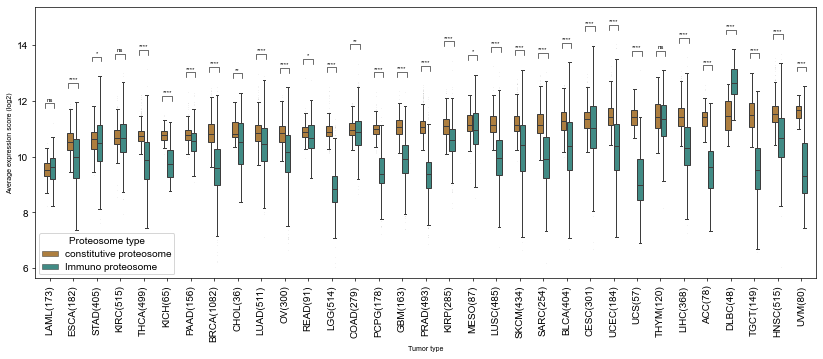

In [71]:
### plotting the constitutve and immunoproteasome in 33 tumor types in ascending order of CP median score
aa=list(const_immuno_df_tcga['Tumor type'].unique())
bb=list(const_immuno_df_tcga['Proteosome type'].unique())
box_pairs=[]
for i in range(33):
    box_pairs.append(((aa[i],bb[0]),(aa[i],bb[1])))
    
plt.figure(figsize=(14,5))
res=sns.boxplot(x="Tumor type",y="Average expression score",hue="Proteosome type",data=const_immuno_df_tcga,order=my_order_tcga,width=.5,linewidth=1,palette={'constitutive proteosome': '#bf812d','Immuno proteosome':'#35978f'},fliersize=.02)
add_stat_annotation(res, data=const_immuno_df_tcga, x="Tumor type", y="Average expression score",hue="Proteosome type",order=my_order_tcga,box_pairs=box_pairs,test='Mann-Whitney',comparisons_correction=None,text_format='star', loc='inside', verbose=2,linewidth=0.7,fontsize = 6)
plt.xticks(rotation=90)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 10)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 10)
plt.setp(res.get_legend().get_texts(), fontsize='10')
plt.setp(res.get_legend().get_title(), fontsize='10')
plt.xlabel("Tumor type",fontsize=7)
plt.ylabel("Average expression score (log2)",fontsize=7)
#plt.savefig("plots/"+'Constitutive_immuno_proteosome_level_v1'+'.svg',bbox_inches = "tight")
plt.show()

### 1.2.CP IP correlation plot in TCGA  tumor samples

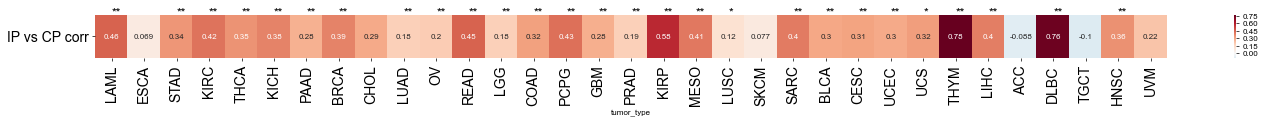

In [72]:
tumor_list=[]
for i in range(len(my_order_tcga)):
    tumor_list.append(list(my_order_tcga)[i].split('(')[0])

conditions=[(corr_p_value_tumor_type_df['p_value'] <= 0.01),(corr_p_value_tumor_type_df['p_value'] > 0.01) & (corr_p_value_tumor_type_df['p_value'] <= 0.05),(corr_p_value_tumor_type_df['p_value'] > 0.05)]
values=['**','*','']
corr_p_value_tumor_type_df['significance'] = np.select(conditions, values)

corr_p_value_tumor_type_df1=corr_p_value_tumor_type_df.set_index('tumor_type').reindex(tumor_list)
fig=plt.figure(figsize=(24,0.8))
res=sns.heatmap(corr_p_value_tumor_type_df1[['IP vs CP corr']].T,annot=True,xticklabels=True, yticklabels=True,cmap="RdBu_r",center=0)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
for i in range(33):
    res.annotate(corr_p_value_tumor_type_df1['significance'][i],xy=(i+0.5,0),fontsize = 12)
#plt.savefig("plots/"+'Corr_value_constitutive_and_immuno'+'.svg',bbox_inches = "tight",dpi=500)
plt.show()

### 2. Analysis of Constitutive and Immuno proteasomes in GTEx normal samples

In [73]:
## reading the GTEx gene expression data
with open('data/gtex_normal/gtex_RSEM_Hugo_norm_count','r') as f:
    listl=[]
    gene_list=[]
    diff_list=[]
    i=0
    for line in f:
        strip_lines=line.strip()
        listli=strip_lines.split()
        m=listl.append(listli)
        gene_list.append(listl[i][0])
        if gene_list[i] in ['PSMB5','PSMB6','PSMB7','PSMB8','PSMB9','PSMB10']:
            diff_list.append(listl[i])
        i=i+1

Gtex_gene_exp_df = pd.DataFrame.from_records(diff_list)
Gtex_gene_exp_df.columns=listl[0]
Gtex_gene_exp_df=Gtex_gene_exp_df.set_index('sample')
Gtex_gene_exp_df=Gtex_gene_exp_df.T
Gtex_gene_exp_df['constitutive_proteosome']=(1/3)*(pd.to_numeric(Gtex_gene_exp_df['PSMB5'])+pd.to_numeric(Gtex_gene_exp_df['PSMB6'])+pd.to_numeric(Gtex_gene_exp_df['PSMB7']))
Gtex_gene_exp_df['immuno_proteosome']=(1/3)*(pd.to_numeric(Gtex_gene_exp_df['PSMB8'])+pd.to_numeric(Gtex_gene_exp_df['PSMB9'])+pd.to_numeric(Gtex_gene_exp_df['PSMB10']))   
Gtex_gene_exp_df.index=Gtex_gene_exp_df.index.str.split('-').str[0:3].str.join('-')

In [74]:
GTEX_tissue_data_id=pd.read_csv("data/gtex_normal/GTExPortal.csv")
GTEX_tissue_data_id1=GTEX_tissue_data_id[['Tissue Sample ID','Tissue']]
GTEX_tissue_data_id1=GTEX_tissue_data_id1.set_index('Tissue Sample ID')
gtex_sample_tissue_type_merge=pd.merge(Gtex_gene_exp_df, GTEX_tissue_data_id1, left_index=True, right_index=True)

tissue_type=list(gtex_sample_tissue_type_merge['Tissue'].unique())
frames1={}
frames2={}
median_const_score=[]
tissue_type1=[]
for i in range(len(tissue_type)):
    tmp_df=gtex_sample_tissue_type_merge[gtex_sample_tissue_type_merge['Tissue']==tissue_type[i]]
    frames2[i]=tmp_df
    const_df=tmp_df[['constitutive_proteosome','Tissue']]
    immuno_df=tmp_df[['immuno_proteosome','Tissue']]
    const_df['proteasome_type']='constitutive_proteosome'
    immuno_df['proteasome_type']='immuno_proteosome'
    const_df=const_df.rename(columns={"constitutive_proteosome":"proteasome_score"})
    immuno_df=immuno_df.rename(columns={"immuno_proteosome":"proteasome_score"})
    const_immuno_df=pd.concat([const_df,immuno_df])
    const_immuno_df=const_immuno_df[const_immuno_df['proteasome_score']>0.0]
    frames1[i]=const_immuno_df
    frames1[i]['Tissue']=frames1[i]['Tissue']+"("+str(round(frames1[i].shape[0]/2))+")"
    tissue_type1.append(tissue_type[i]+"("+str(round(frames1[i].shape[0]/2))+")")
    
    median_const_score.append(np.median(const_df['proteasome_score']))
    
const_immuno_df_concat=pd.concat(frames1)

### for ordering the boxplot===============================================
median_const_df=pd.DataFrame()
median_const_df['Tumor type']=tissue_type1
median_const_df['median_const_score']=median_const_score
median_const_df=median_const_df[~median_const_df['Tumor type'].isin(['Fallopian Tube(5)', 'Cervix - Ectocervix(6)', 'Cervix - Endocervix(4)'])]
my_order_gtex=median_const_df.sort_values(by=['median_const_score'])['Tumor type'] ### order the box plot and correlation plot based on the median score of const proteasome
###==========================================================================

box_pairs=[]
for i in range(len(tissue_type)):
    box_pairs.append(((tissue_type1[i],'constitutive_proteosome'),(tissue_type1[i],'immuno_proteosome')))


#### Creating files for supplementary ############################
CP_IP_GTEX=pd.concat(frames2)
CP_IP_GTEX1=CP_IP_GTEX[~CP_IP_GTEX['Tissue'].isin(['Fallopian Tube', 'Cervix - Ectocervix', 'Cervix - Endocervix'])]
CP_IP_GTEX2=CP_IP_GTEX1[(CP_IP_GTEX1['constitutive_proteosome']>0)|(CP_IP_GTEX1['immuno_proteosome']>0)]

CP_IP_GTEX2= CP_IP_GTEX2.reset_index(level=[0])
CP_IP_GTEX2=CP_IP_GTEX2.drop(['level_0'],axis=1)
CP_IP_GTEX2=CP_IP_GTEX2.reindex(columns=['PSMB5','PSMB6','PSMB7','PSMB8','PSMB9','PSMB10','constitutive_proteosome','immuno_proteosome','Tissue'])
####------------------------------------------

In [75]:
cp_ip={'constitutive_proteosome': '#bf812d', 'immuno_proteosome': '#35978f'}

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Adipose - Subcutaneous(318)_constitutive_proteosome v.s. Adipose - Subcutaneous(318)_immuno_proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=1.559e-88 U_stat=9.678e+04
Artery - Tibial(281)_constitutive_proteosome v.s. Artery - Tibial(281)_immuno_proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=2.270e-93 U_stat=7.893e+04
Artery - Coronary(118)_constitutive_proteosome v.s. Artery - Coronary(118)_immuno_proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=1.302e-39 U_stat=1.387e+04
Heart - Atrial Appendage(174)_constitutive_proteosome v.s. Heart - Atrial Appendage(174)_immuno_proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=1.525e-58 U_stat=3.028e+04
Adipose - Visceral (Omentum)(197)_constitutive_proteosome v.s. Adipose - Visceral (Omentum)(197)_immuno_proteosome: Mann-Whitney-Wilcoxon test two-sided, P_

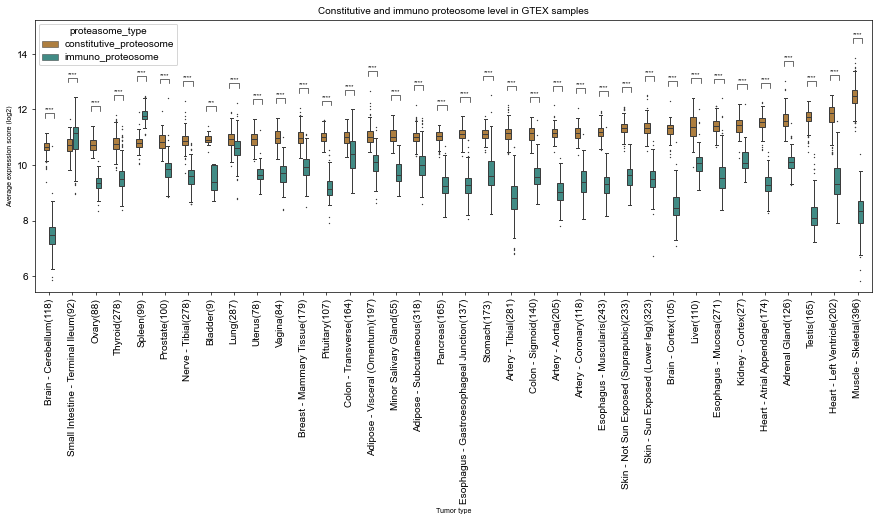

In [76]:
## Plotting CP and IP expression in GTEx normal tissue
const_immuno_df_concat['proteasome_score'] = const_immuno_df_concat['proteasome_score'].astype(float)
const_immuno_df_concat=const_immuno_df_concat[~const_immuno_df_concat['Tissue'].isin(['Fallopian Tube(5)', 'Cervix - Ectocervix(6)', 'Cervix - Endocervix(4)'])]
tissue_type=list(const_immuno_df_concat['Tissue'].unique())
box_pairs=[]
for i in range(len(tissue_type)):
    box_pairs.append(((tissue_type[i],'constitutive_proteosome'),(tissue_type[i],'immuno_proteosome')))

plt.figure(figsize=(15,5))
res=sns.boxplot(x='Tissue',y='proteasome_score',hue='proteasome_type',data=const_immuno_df_concat,order=my_order_gtex,width=.5,linewidth=1,fliersize=.5,palette=cp_ip)
add_stat_annotation(res, data=const_immuno_df_concat, x="Tissue", y="proteasome_score",hue="proteasome_type",order=my_order_gtex,box_pairs=box_pairs,test='Mann-Whitney',comparisons_correction=None, text_format='star', loc='inside', verbose=2,linewidth=0.7,fontsize = 6)
plt.xticks(rotation=90)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 10)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 10)
plt.setp(res.get_legend().get_texts(), fontsize='10')
plt.setp(res.get_legend().get_title(), fontsize='10')
plt.xlabel("Tumor type",fontsize=7)
plt.ylabel("Average expression score (log2)",fontsize=7)
plt.title('Constitutive and immuno proteosome level in GTEX samples',fontsize=10)
#plt.savefig("plots/"+'GTEX_constitutive_immuno'+'.svg',bbox_inches = "tight")
plt.show()

### 3. CP IP correlation plot in GTEx normal tissue

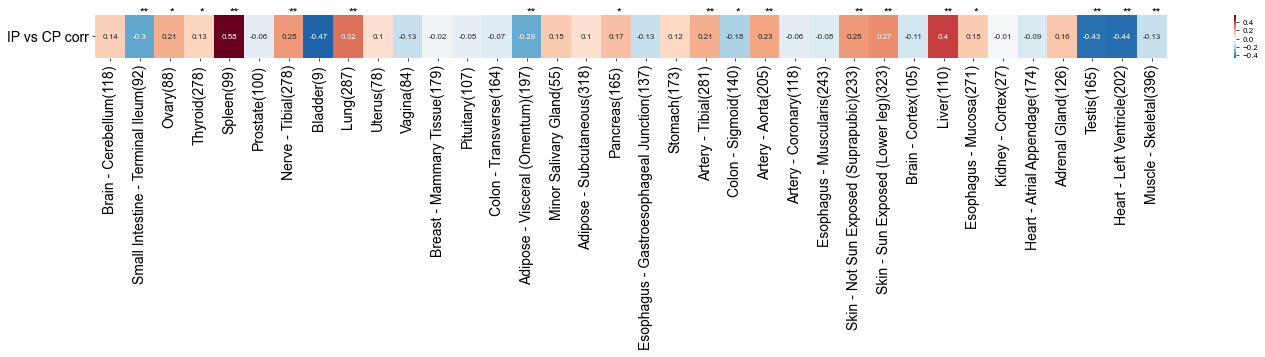

In [77]:
tissue_type=list(const_immuno_df_concat['Tissue'].unique())
corr_value_list=[]
p_value_list=[]
for i in range(len(tissue_type)):
    a=const_immuno_df_concat[(const_immuno_df_concat['Tissue']==tissue_type[i])&(const_immuno_df_concat['proteasome_type']=='constitutive_proteosome')]['proteasome_score']
    b=const_immuno_df_concat[(const_immuno_df_concat['Tissue']==tissue_type[i])&(const_immuno_df_concat['proteasome_type']=='immuno_proteosome')]['proteasome_score']
    correlation, p_value = stats.spearmanr(a,b)
    corr_value_list.append(correlation)
    p_value_list.append(p_value)

corr_value_list
df=pd.DataFrame()
df['IP vs CP corr']=np.round(corr_value_list,2)
df['p_value']=p_value_list
df.index=tissue_type
df=df.loc[my_order_gtex]

#df['significance']=np.nan
conditions=[(df['p_value'] <= 0.01),(df['p_value'] > 0.01) & (df['p_value'] <= 0.05),(df['p_value'] > 0.05)]
values=['**','*','']
df['significance'] = np.select(conditions, values)
df.to_csv('/workspace/projects/immunoproteasome/'+'GTEx_cp_ip_corr'+'.csv') ### saving the GTEx cp-ip correlation value

fig=plt.figure(figsize=(24,0.8))
res=sns.heatmap(df[['IP vs CP corr']].T,annot=True,xticklabels=True, yticklabels=True,cmap="RdBu_r",center=0,annot_kws={"fontsize":8})
#res=sns.heatmap(df[['p_value']].T)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14,rotation = 0)
for i in range(36):
    res.annotate(df['significance'][i],xy=(i+0.5,0),fontsize = 12)
    
#plt.savefig("plots/"+'GTEX_normal_correlation_constitutive_immuno'+'.svg',bbox_inches = "tight",dpi=500)
plt.show()

### 3. GTEx normal and  TCGA_tumor sample analysis

In [78]:
### Reading the GTEx normal gene expression data 
with open('data/gtex_normal/gtex_RSEM_Hugo_norm_count','r') as f:
    listl=[]
    gene_list=[]
    diff_list=[]
    i=0
    for line in f:
        strip_lines=line.strip()
        listli=strip_lines.split()
        m=listl.append(listli)
        gene_list.append(listl[i][0])
        if gene_list[i] in ['PSMB5','PSMB6','PSMB7','PSMB8','PSMB9','PSMB10']:
            diff_list.append(listl[i])
        i=i+1

GTEx_df = pd.DataFrame.from_records(diff_list)
GTEx_df.columns=listl[0]
GTEx_df=GTEx_df.set_index('sample')

GTEx_df=GTEx_df.T
GTEx_df['constitutive_proteosome']=(1/3)*(pd.to_numeric(GTEx_df['PSMB5'])+pd.to_numeric(GTEx_df['PSMB6'])+pd.to_numeric(GTEx_df['PSMB7']))
GTEx_df['immuno_proteosome']=(1/3)*(pd.to_numeric(GTEx_df['PSMB8'])+pd.to_numeric(GTEx_df['PSMB9'])+pd.to_numeric(GTEx_df['PSMB10']))  
GTEx_df.index=GTEx_df.index.str.split('-').str[0:3].str.join('-')

In [79]:
### Dictionary to map GTEx tissue type with the coreesponding Tumor tissue type
my_dict_GTEx = {
  "Bladder":"BLCA",
  "Breast - Mammary Tissue":"BRCA",
  "Cervix - Ectocervix":"CESC",
  "Cervix - Endocervix":"CESC",
  "Uterus":"UCEC",
  "Colon - Sigmoid":"READ",
  "Colon - Transverse":"COAD",
  "Liver":"LIHC",
  "Minor Salivary Gland":"HNSC",
  "Esophagus - Mucosa":"ESCA",
  "Esophagus - Muscularis":"ESCA",
  "Esophagus - Gastroesophageal Junction":"ESCA",
  "Prostate":"PRAD",
  "Stomach":"STAD",
  "Thyroid":"THCA",
  "Lung":"LUAD",
  "Kidney - Cortex":"KIRC",
  "Skin - Sun Exposed (Lower leg)":"SKCM",
  "Skin - Not Sun Exposed (Suprapubic)":"SKCM",
  "Adipose - Subcutaneous":"SARC",
  "Nerve - Tibial":"SARC",
  "Muscle - Skeletal":"SARC",
  "Adipose - Visceral (Omentum)":"SARC",
  "Pancreas":"PAAD",
  "Ovary":"OV",
  "Uterus":"UCEC",
  "Brain - Cortex":"GBM",
  "Brain - Cerebellum":"GBM",
  "Adrenal Gland":"ACC",
  "Testis":"TGCT",
  "Kidney - Medulla":"KIRC"
}

In [80]:
GTEX_tissue_data_id=pd.read_csv("data/gtex_normal/GTExPortal.csv")
GTEx_tumor_list=['Bladder','Breast - Mammary Tissue','Cervix - Ectocervix','Cervix - Endocervix','Uterus','Colon - Sigmoid','Colon - Transverse','Liver','Minor Salivary Gland','Esophagus - Mucosa','Esophagus - Muscularis','Esophagus - Gastroesophageal Junction','Prostate','Stomach','Thyroid','Lung','Kidney - Cortex',"Skin - Sun Exposed (Lower leg)","Skin - Not Sun Exposed (Suprapubic)","Adipose - Subcutaneous","Nerve - Tibial","Muscle - Skeletal","Adipose - Visceral (Omentum)","Pancreas","Ovary","Uterus","Brain - Cortex","Brain - Cerebellum","Adrenal Gland","Testis","Kidney - Medulla"]
GTEX_tissue_data_id_tmp=GTEX_tissue_data_id
GTEX_tissue_data_id_tmp=GTEX_tissue_data_id_tmp[GTEX_tissue_data_id['Tissue'].isin(GTEx_tumor_list)]
GTEX_tissue_data_id_tmp=GTEX_tissue_data_id_tmp.replace({"Tissue":my_dict_GTEx })

GTEX_tissue_data_id1=GTEX_tissue_data_id_tmp[['Tissue Sample ID','Tissue']]
GTEX_tissue_data_id1=GTEX_tissue_data_id1.set_index('Tissue Sample ID')
gtex_sample_tissue_type_merge=pd.merge(GTEx_df, GTEX_tissue_data_id1, left_index=True, right_index=True)

tissue_type=list(gtex_sample_tissue_type_merge['Tissue'].unique())
frames1={}
for i in range(len(tissue_type)):
    dff=gtex_sample_tissue_type_merge[gtex_sample_tissue_type_merge['Tissue']==tissue_type[i]]
    df_const=dff[['constitutive_proteosome','Tissue']]
    df_immuno=dff[['immuno_proteosome','Tissue']]
    df_const['proteasome_type']='constitutive_proteosome'
    df_immuno['proteasome_type']='immuno_proteosome'
    df_const=df_const.rename(columns={"constitutive_proteosome":"proteasome_score"})
    df_immuno=df_immuno.rename(columns={"immuno_proteosome":"proteasome_score"})
    df_const_immuno=pd.concat([df_const,df_immuno])
    frames1[i]=df_const_immuno
dff4=pd.concat(frames1)

###----------- dataframe for supplementary file ----------------------------------
gtex_sample_id_tt=gtex_sample_tissue_type_merge[['Tissue']]
gtex_sample_id_tt = gtex_sample_id_tt[~gtex_sample_id_tt.index.duplicated(keep='first')]

In [81]:
### Computing TCGA tumor median score of constituive and immunoproteasome
tcga_tumor_const_proteasome=[]
tcga_tumor_immuno_proteasome=[]
tcga_tissue_type=list(const_immuno_df_tcga['Tumor type'].unique())
tcga_tumor_median_proteasome_score=pd.DataFrame()
for i in range(len(tcga_tissue_type)):
    tcga_tumor_const_proteasome.append(np.median(const_immuno_df_tcga[(const_immuno_df_tcga['Tumor type']==tcga_tissue_type[i])&(const_immuno_df_tcga['Proteosome type']=='constitutive proteosome')]['Average expression score']))
    tcga_tumor_immuno_proteasome.append(np.median(const_immuno_df_tcga[(const_immuno_df_tcga['Tumor type']==tcga_tissue_type[i])&(const_immuno_df_tcga['Proteosome type']=='Immuno proteosome')]['Average expression score']))

tcga_tumor_median_proteasome_score['tcga_tumor_const_proteasome']=tcga_tumor_const_proteasome
tcga_tumor_median_proteasome_score['tcga_tumor_immuno_proteasome']=tcga_tumor_immuno_proteasome
tcga_tumor_median_proteasome_score['Tissue type']=tcga_tissue_type
tcga_tumor_median_proteasome_score['Tissue type']=tcga_tumor_median_proteasome_score['Tissue type'].str.split('(').str[0:1].str.join('.')

tcga_tumor_median_proteasome_score['tcga_median_proteasome_difference']=tcga_tumor_median_proteasome_score['tcga_tumor_const_proteasome']-tcga_tumor_median_proteasome_score['tcga_tumor_immuno_proteasome']

## Compute  TCGA and GTEx median proteasome score
gtex_const_proteasome=[]
gtex_immuno_proteasome=[]
gtex_tissue_type=list(dff4['Tissue'].unique())
gtex_median_proteasome_score=pd.DataFrame()
for i in range(len(gtex_tissue_type)):
    gtex_const_proteasome.append(np.median(dff4[(dff4['Tissue']==gtex_tissue_type[i])&(dff4['proteasome_type']=='constitutive_proteosome')]['proteasome_score']))
    gtex_immuno_proteasome.append(np.median(dff4[(dff4['Tissue']==gtex_tissue_type[i])&(dff4['proteasome_type']=='immuno_proteosome')]['proteasome_score']))

gtex_median_proteasome_score['gtex_const_proteasome']=gtex_const_proteasome
gtex_median_proteasome_score['gtex_immuno_proteasome']=gtex_immuno_proteasome
gtex_median_proteasome_score['Tissue type']=gtex_tissue_type

gtex_median_proteasome_score['gtex_median_proteasome_difference']=gtex_median_proteasome_score['gtex_const_proteasome']-gtex_median_proteasome_score['gtex_immuno_proteasome']
gtex_tcga_median_proteasome_diff=pd.merge(tcga_tumor_median_proteasome_score,gtex_median_proteasome_score,on='Tissue type')
gtex_tcga_median_proteasome_diff1=gtex_tcga_median_proteasome_diff[['Tissue type','tcga_median_proteasome_difference','gtex_median_proteasome_difference']]


### 1. TCGA and GTEx median IP score scatter plot

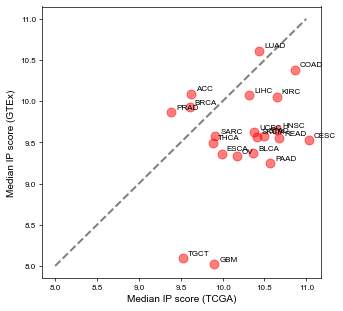

In [82]:
x = list(gtex_tcga_median_proteasome_diff['tcga_tumor_immuno_proteasome'])  # x_list
y = list(gtex_tcga_median_proteasome_diff['gtex_immuno_proteasome']) #y_list
labels = list(gtex_tcga_median_proteasome_diff1['Tissue type']) #tumor_list

fig, ax = plt.subplots(figsize=(5, 5))
# Plot the scatter points
ax.scatter(x, y,
           color="red",  # Color of the dots
           s=80,         # Size of the dots
           alpha=0.5,     # Alpha of the dots
           linewidths=1)  # Size of edge around the dots
ax.set_xlabel('Median IP score (TCGA)',size=10)
ax.set_ylabel('Median IP score (GTEx)',size=10)

plt.plot([8, 11], [8, 11], color = 'black', linewidth = 2.0,alpha=0.5,linestyle="dashed")

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(5, 5),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='left',         # Horizontally aligned to the left
                va='center')       # Vertical alignment is centered
#plt.savefig("plots/"+'median_immuno_score_TCGA_tumor_gtex_normal'+'.svg',bbox_inches = "tight",dpi=500)
#plt.show()

### 2. TCGA and GTEx median CP score scatter plot

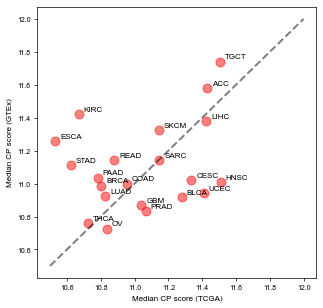

In [83]:
x = list(gtex_tcga_median_proteasome_diff['tcga_tumor_const_proteasome'])  # x_list
y = list(gtex_tcga_median_proteasome_diff['gtex_const_proteasome']) #y_list
labels = list(gtex_tcga_median_proteasome_diff1['Tissue type']) #tumor_list

fig, ax = plt.subplots(figsize=(5, 5))
# Plot the scatter points
ax.scatter(x, y,
           color="red",  # Color of the dots
           s=80,         # Size of the dots
           alpha=0.5,     # Alpha of the dots
           linewidths=1)  # Size of edge around the dots
ax.set_xlabel('Median CP score (TCGA)',size=8)
ax.set_ylabel('Median CP score (GTEx)',size=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.plot([10.5, 12], [10.5, 12], color = 'black', linewidth = 2.0,alpha=0.5,linestyle="dashed")


# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(5, 5),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='left',         # Horizontally aligned to the left
                va='center')       # Vertical alignment is centered
#plt.savefig("plots/"+'median_constitutive_score_TCGA_tumor_gtex_normal'+'.svg',bbox_inches = "tight",dpi=500)
#plt.show()

### 3. Difference of the median CP and IP  score in GTEx normal and TCGA tumor sample

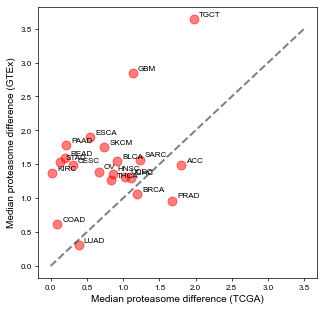

In [84]:
x = list(gtex_tcga_median_proteasome_diff1['tcga_median_proteasome_difference'])  # x_list
y = list(gtex_tcga_median_proteasome_diff1['gtex_median_proteasome_difference']) #y_list
labels = list(gtex_tcga_median_proteasome_diff1['Tissue type']) #tumor_list

fig, ax = plt.subplots(figsize=(5, 5))
# Plot the scatter points
ax.scatter(x, y,
           color="red",  # Color of the dots
           s=80,         # Size of the dots
           alpha=0.5,     # Alpha of the dots
           linewidths=1)  # Size of edge around the dots
ax.set_xlabel('Median proteasome difference (TCGA)',size=10)
ax.set_ylabel('Median proteasome difference (GTEx)',size=10)


plt.plot([0, 3.5], [0, 3.5], color = 'black', linewidth = 2.0,alpha=0.5,linestyle="dashed")
#ax.xlim(0,2)
#ax.ylim(0,2)

# Add the participant names as text labels for each point
for x_pos, y_pos, label in zip(x, y, labels):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(5, 5),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                ha='left',         # Horizontally aligned to the left
                va='center')       # Vertical alignment is centered

#plt.savefig("plots/"+'median_difference_constitutive_immuno_TCGA_tumor_gtex_normal'+'.svg',bbox_inches = "tight",dpi=500)
#plt.show()

### 1. Creating low and high IP group samples

In [85]:
## listing the data file name
os.chdir("data/tcga_tumor/")
tumor_list=[]
for  i in glob.glob("*.tsv"):
    tumor_list.append(i)

In [86]:
input_path1 = "data/tcga_tumor/"
low_immuno_df=[]
high_immuno_df=[]
for i in range(33):
    gene_data_frame=pd.read_csv(input_path1+tumor_list[i],sep='\t',index_col='Hybridization REF')
    
    gene_data_frame.columns=gene_data_frame.columns.str.split('-').str[0:3].str.join('.')
    gene_data_frame.to_csv('data/r_input/gene_exp'+'gene_exp_'+tumor_list[i].split('.')[0]+'.csv') ## save gene expression dataframe

    gene_data_frame=gene_data_frame.T
    gene_data_frame=np.log2(gene_data_frame+1)
    gene_data_frame['const_proteosome']=(1/3)*(gene_data_frame['PSMB5']+gene_data_frame['PSMB6']+gene_data_frame['PSMB7'])
    gene_data_frame['immuno_proteosome']=(1/3)*(gene_data_frame['PSMB8']+gene_data_frame['PSMB9']+gene_data_frame['PSMB10'])
    
    low_immuno=gene_data_frame[gene_data_frame['immuno_proteosome']<np.percentile(gene_data_frame['immuno_proteosome'],[25, 50, 75])[0]]
    high_immuno=gene_data_frame[gene_data_frame['immuno_proteosome']>np.percentile(gene_data_frame['immuno_proteosome'],[25, 50, 75])[2]]
    
    low_immuno=low_immuno[['immuno_proteosome']]
    low_immuno['immuno_proteosome_status']='low'
    low_immuno['tumor_type']=tumor_list[i].split('.')[0]   ### Change constitutive and immunoproteasome to generate high and low IP and CP samples
    
    high_immuno=high_immuno[['immuno_proteosome']]
    high_immuno['immuno_proteosome_status']='high'
    high_immuno['tumor_type']=tumor_list[i].split('.')[0]
    

    low_immuno_df.append(low_immuno)
    high_immuno_df.append(high_immuno)
    
df1=pd.concat(low_immuno_df)
df2=pd.concat(high_immuno_df)
final_df_IP=pd.concat([df1,df2])
final_df_IP.to_csv('data/r_input/'+'high_low_ip'+'.csv') ## saving sample_id information in low and high immunoproteasome group

### 2. Creating low and high CP group sample

In [87]:
input_path1 = "data/tcga_tumor/"
low_const_df=[]
high_const_df=[]
for i in range(33):
    gene_data_frame=pd.read_csv(input_path1+tumor_list[i],sep='\t',index_col='Hybridization REF')
    
    gene_data_frame.columns=gene_data_frame.columns.str.split('-').str[0:3].str.join('.')
    gene_data_frame.to_csv('data/r_input/gene_exp/'+'gene_exp_'+tumor_list[i].split('.')[0]+'.csv') ## save gene expression dataframe
    
    gene_data_frame=gene_data_frame.T
    gene_data_frame=np.log2(gene_data_frame+1)
    gene_data_frame['const_proteosome']=(1/3)*(gene_data_frame['PSMB5']+gene_data_frame['PSMB6']+gene_data_frame['PSMB7'])
    gene_data_frame['immuno_proteosome']=(1/3)*(gene_data_frame['PSMB8']+gene_data_frame['PSMB9']+gene_data_frame['PSMB10'])
    
    low_const=gene_data_frame[gene_data_frame['const_proteosome']<np.percentile(gene_data_frame['const_proteosome'],[25, 50, 75])[0]]
    high_const=gene_data_frame[gene_data_frame['const_proteosome']>np.percentile(gene_data_frame['const_proteosome'],[25, 50, 75])[2]]
    
    low_const=low_const[['const_proteosome']]
    low_const['const_proteosome_status']='low'
    low_const['tumor_type']=tumor_list[i].split('.')[0]   ### Change constitutive and immunoproteasome to generate high and low IP and CP samples
    
    high_const=high_const[['const_proteosome']]
    high_const['const_proteosome_status']='high'
    high_const['tumor_type']=tumor_list[i].split('.')[0]
    

    low_const_df.append(low_const)
    high_const_df.append(high_const)
    
df1=pd.concat(low_const_df)
df2=pd.concat(high_const_df)
final_df_CP=pd.concat([df1,df2])
final_df_CP.to_csv('data/r_input/'+'high_low_cp'+'.csv') ## saving sample_id information in low and high immunoproteasome group

In [88]:
final_df_CP1=final_df_CP[['const_proteosome_status','tumor_type']]
final_df_IP1=final_df_IP[['immuno_proteosome_status','tumor_type']]

### Supplementary_figure1

In [89]:
list_of_tumor_filename=[]
for i in range(33):
    list_of_tumor_filename.append(list(my_order_tcga)[i].split('(')[0])

In [90]:
## Reading purity data
tumor_purity_df=pd.read_csv("data/TCGA_mastercalls.abs_tables_JSedit.fixed.txt",sep='\t')
tumor_purity_df['sample_id']=tumor_purity_df['array'].str.split('-').str[0:3].str.join('.')
tumor_purity_df=tumor_purity_df[['purity','sample_id']]
tumor_purity_df=tumor_purity_df.set_index('sample_id')

In [91]:
input_path1="data/tcga_tumor/"
frames={}

tumor_list=[]
corr_p_value_tumor_type_df=pd.DataFrame()
corr_list=[]
p_value_list=[]
frames1={}

for i in range(len(list_of_tumor_filename)):
    gene_data_frame=pd.read_csv(input_path1+list_of_tumor_filename[i]+'.tsv',index_col='Hybridization REF',sep='\t')
    gene_data_frame.columns=gene_data_frame.columns.str.split('-').str[0:3].str.join('.')
    gene_data_frame=gene_data_frame.T
    log_gene_data_frame=np.log2(gene_data_frame[['PSMB5','PSMB6','PSMB7','PSMB8','PSMB9','PSMB10']]+1)
    
    log_gene_data_frame['constitutive_proteosome']=(1/3)*(log_gene_data_frame['PSMB5']+log_gene_data_frame['PSMB6']+log_gene_data_frame['PSMB7'])
    log_gene_data_frame['immuno_proteosome']=(1/3)*(log_gene_data_frame['PSMB8']+log_gene_data_frame['PSMB9']+log_gene_data_frame['PSMB10'])
    
    merged_df=pd.merge(log_gene_data_frame,tumor_purity_df,left_index=True, right_index=True)
    log_gene_data_frame1=merged_df[merged_df['purity']>0.7] 
    
    ### computing correlation value ################################
    correlation, p_value = stats.spearmanr(log_gene_data_frame1['constitutive_proteosome'], log_gene_data_frame1['immuno_proteosome'])
    corr_list.append(correlation)  
    tumor_list.append(list_of_tumor_filename[i].split('.')[0])
    p_value_list.append(p_value)
    #####===============================================================
    
    extracted_df=log_gene_data_frame1[['constitutive_proteosome','immuno_proteosome']]
    
    frames[i]=log_gene_data_frame1[['constitutive_proteosome','immuno_proteosome']]
    frames[i]['Tumor type']=list_of_tumor_filename[i].split('.')[0]+"("+str(extracted_df.shape[0])+")"
    
### correlation value dataframe
corr_p_value_tumor_type_df['tumor_type']=tumor_list
corr_p_value_tumor_type_df['IP vs CP corr']=corr_list    
corr_p_value_tumor_type_df['p_value']=p_value_list
corr_p_value_tumor_type_df['IP vs CP corr']=np.round(corr_p_value_tumor_type_df['IP vs CP corr'],2)
##=======================================================
concat_df=pd.concat(frames)
###====for ordering the boxplot
my_order=list(concat_df['Tumor type'].unique())
###==========================================================================

const_df=concat_df[['constitutive_proteosome','Tumor type']]
immuno_df=concat_df[['immuno_proteosome','Tumor type']]
const_df['Proteosome type']='constitutive proteosome'
const_df=const_df.rename(columns={'constitutive_proteosome':'Average expression score'})
immuno_df['Proteosome type']='Immuno proteosome'
immuno_df=immuno_df.rename(columns={'immuno_proteosome':'Average expression score'})
const_immuno_df_tcga=pd.concat([const_df,immuno_df])

#### Creating files for supplementary #####################################
#CP_IP_TCGA=pd.concat(frames)
#CP_IP_TCGA1= CP_IP_TCGA.reset_index(level=[0])
#CP_IP_TCGA1=CP_IP_TCGA1.drop(['level_0'],axis=1)
#CP_IP_TCGA1=CP_IP_TCGA1.reindex(columns=['PSMB5','PSMB6','PSMB7','PSMB8','PSMB9','PSMB10','constitutive_proteosome','immuno_proteosome','Tumor tissue'])
####-----------------------------------------------------------------

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

LUAD(48)_constitutive proteosome v.s. LUAD(48)_Immuno proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=2.279e-12 U_stat=2.110e+03
OV(212)_constitutive proteosome v.s. OV(212)_Immuno proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=1.904e-21 U_stat=3.447e+04
READ(35)_constitutive proteosome v.s. READ(35)_Immuno proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=5.706e-02 U_stat=7.750e+02
LGG(318)_constitutive proteosome v.s. LGG(318)_Immuno proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=3.312e-100 U_stat=9.980e+04
COAD(106)_constitutive proteosome v.s. COAD(106)_Immuno proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=1.201e-04 U_stat=7.336e+03
PCPG(93)_constitutive proteosome v.s. PCPG(93)_Immuno proteosome: Mann-Whitney-Wilcoxon test two-sided, P_val=2.801e-30 U_stat=8.523e+03
GBM(103)_cons

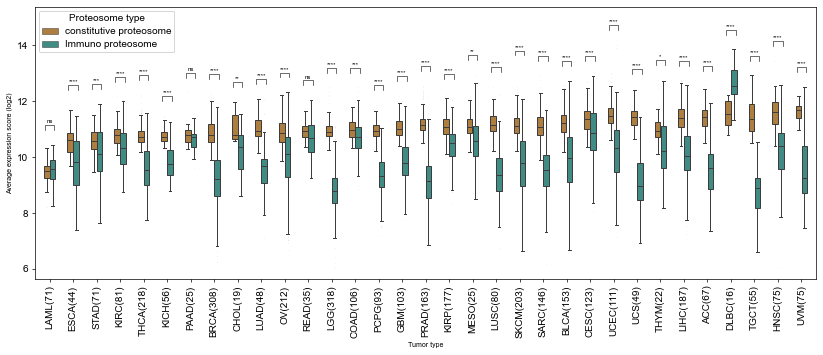

In [92]:
### plotting the CP and IP expression level in pure TCGA samples(purity>70%)
aa=list(const_immuno_df_tcga['Tumor type'].unique())
bb=list(const_immuno_df_tcga['Proteosome type'].unique())
box_pairs=[]
for i in range(33):
    box_pairs.append(((aa[i],bb[0]),(aa[i],bb[1])))

plt.figure(figsize=(14,5))
res=sns.boxplot(x="Tumor type",y="Average expression score",hue="Proteosome type",data=const_immuno_df_tcga,order=my_order,width=.5,linewidth=1,palette={'constitutive proteosome': '#bf812d','Immuno proteosome':'#35978f'},fliersize=.02)
add_stat_annotation(res, data=const_immuno_df_tcga, x="Tumor type", y="Average expression score",hue="Proteosome type",order=my_order,box_pairs=box_pairs,test='Mann-Whitney',comparisons_correction=None,text_format='star', loc='inside', verbose=2,linewidth=0.7,fontsize = 6)
plt.xticks(rotation=90)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 10)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 10)
plt.setp(res.get_legend().get_texts(), fontsize='10')
plt.setp(res.get_legend().get_title(), fontsize='10')
plt.xlabel("Tumor type",fontsize=7)
plt.ylabel("Average expression score (log2)",fontsize=7)
#plt.savefig("plots/"+'Constitutive_immuno_proteosome_level_purity_0.7'+'.svg',bbox_inches = "tight")
plt.show()

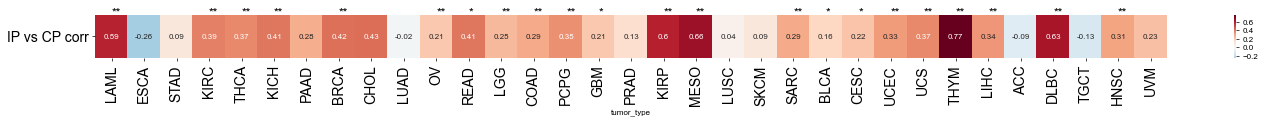

In [93]:
### Correaltion heatmap in TCGA samples having purity(>70%) 
corr_p_value_tumor_type_df.sort_values(by=['IP vs CP corr'],inplace=True)
corr_p_value_tumor_type_df.index=list(range(0,33))
conditions=[(corr_p_value_tumor_type_df['p_value'] <= 0.01),(corr_p_value_tumor_type_df['p_value'] > 0.01) & (corr_p_value_tumor_type_df['p_value'] <= 0.05),(corr_p_value_tumor_type_df['p_value'] > 0.05)]
values=['**','*','']
corr_p_value_tumor_type_df['significance'] = np.select(conditions, values)
corr_p_value_tumor_type_df.to_csv('/workspace/projects/immunoproteasome/'+'TCGA_cp_ip_corr'+'.csv')

df_tmp=corr_p_value_tumor_type_df
df_tmp1=df_tmp[['tumor_type','IP vs CP corr','p_value','significance']].set_index('tumor_type')
df_tmp1=df_tmp1.reindex(tumor_list)
fig=plt.figure(figsize=(24,0.8))
df_tmp2=df_tmp1[['IP vs CP corr','significance']]
res=sns.heatmap(df_tmp2[['IP vs CP corr']].T,annot=True,xticklabels=True, yticklabels=True,cmap="RdBu_r",center=0)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
for i in range(33):
    res.annotate(df_tmp2['significance'][i],xy=(i+0.5,0),fontsize = 12)
#plt.savefig("plots/"+'Corr_value_constitutive_and_immuno_purity_0.7'+'.svg',bbox_inches = "tight",dpi=500)
plt.show()

### Supplementarty TableS1 

In [94]:
with pd.ExcelWriter('supplementary_tables/TableS1.xlsx') as writer:   
    CP_IP_TCGA1.to_excel(writer, sheet_name='Sheet_name_1')
    CP_IP_GTEX2.to_excel(writer, sheet_name='Sheet_name_2')
    gtex_sample_id_tt.to_excel(writer, sheet_name='Sheet_name_3')
    final_df_IP1.to_excel(writer, sheet_name='Sheet_name_4')
    final_df_CP1.to_excel(writer, sheet_name='Sheet_name_5')